In [1]:
import pandas as pd

In [2]:
import datetime

## Table 1: Bike demand

**Station_Start | Timestamp | Count**

How many bikes where used at a station per hour

In [3]:
table1 = pd.read_csv('relevant_hourly_rentals.csv', sep='|', header=None)

In [4]:
table1.columns=['START_RENTAL_ZONE_HAL_ID', 'Timestamp', 'Count']

In [5]:
table1['Timestamp'] = pd.to_datetime(table1['Timestamp'])

In [6]:
table1.head()

,START_RENTAL_ZONE_HAL_ID,Timestamp,Count
0,131547.0,2014-01-01,5
1,131645.0,2014-01-01,3
2,131646.0,2014-01-01,3
3,131648.0,2014-01-01,1
4,131650.0,2014-01-01,2


In [9]:
table1 = table1.dropna()

In [11]:
table1[table1.isnull().any(axis=1)]

,START_RENTAL_ZONE_HAL_ID,Timestamp,Count


---

## Table 2: weather data

**Timestamp | Temperature | Windspeed | Rain**

In [12]:
table2 = pd.read_csv('DB_weather.csv', sep=';')
del table2["Unnamed: 0"]
table2.head()

,Time,Temp,Wind speed,Rain
0,01.01.2014 00:00,2.4,4,0
1,01.01.2014 01:00,2.1,6,0
2,01.01.2014 02:00,2.0,5,0
3,01.01.2014 03:00,2.1,5,0
4,01.01.2014 04:00,1.6,5,0


In [13]:
table2.columns=['Timestamp', 'Temp', 'Windspeed', 'Rain']

In [14]:
table2['Timestamp'] = pd.to_datetime(table2['Timestamp'])

In [15]:
table2.shape

(18475, 4)

In [17]:
table2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18475 entries, 0 to 18474
Data columns (total 4 columns):
Timestamp    18475 non-null datetime64[ns]
Temp         18475 non-null float64
Windspeed    18475 non-null int64
Rain         18475 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 577.5 KB


---

## Table 3

**Timestamp | year | month | day | weekday | hour | holiday | not_workday | not_workday_shift | school_holiday**

In [18]:
table3 = pd.DataFrame(table2['Timestamp'])

In [19]:
table3.head()

,Timestamp
0,2014-01-01 00:00:00
1,2014-01-01 01:00:00
2,2014-01-01 02:00:00
3,2014-01-01 03:00:00
4,2014-01-01 04:00:00


In [20]:
table3['year'] = table3['Timestamp'].dt.year
table3['month'] = table3['Timestamp'].dt.month
table3['day'] = table3['Timestamp'].dt.day
table3['weekday'] = table3['Timestamp'].dt.weekday
table3['hour'] = table3['Timestamp'].dt.hour

---

#### public holidays in HH

In [22]:
!pip install holidays

In [23]:
from datetime import date
import holidays

In [24]:
hh_holidays = holidays.CountryHoliday('DE', prov='HH')

In [25]:
# Necessary to initialise hh_holidays array
date(2014, 1, 1) in hh_holidays
date(2015, 1, 1) in hh_holidays
date(2016, 1, 1) in hh_holidays

True

In [26]:
hh_holidays = pd.DataFrame(list(hh_holidays.keys()))

In [27]:
hh_holidays['holiday']='1'

In [28]:
hh_holidays.columns=['Timestamp', 'holiday'] 

In [29]:
hh_holidays['Timestamp'] = pd.to_datetime(hh_holidays['Timestamp'])
hh_holidays["shortTime"] = hh_holidays["Timestamp"].apply(lambda row : row.strftime("%Y-%m-%d"))

In [30]:
hh_holidays.head()

,Timestamp,holiday,shortTime
0,2014-01-01,1,2014-01-01
1,2014-04-18,1,2014-04-18
2,2014-04-21,1,2014-04-21
3,2014-05-01,1,2014-05-01
4,2014-05-29,1,2014-05-29


In [31]:
hh_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
Timestamp    27 non-null datetime64[ns]
holiday      27 non-null object
shortTime    27 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 776.0+ bytes


In [32]:
table3["shortTime"] = table3["Timestamp"].apply(lambda row : row.strftime("%Y-%m-%d"))
table3.head()

,Timestamp,year,month,day,weekday,hour,shortTime
0,2014-01-01 00:00:00,2014,1,1,2,0,2014-01-01
1,2014-01-01 01:00:00,2014,1,1,2,1,2014-01-01
2,2014-01-01 02:00:00,2014,1,1,2,2,2014-01-01
3,2014-01-01 03:00:00,2014,1,1,2,3,2014-01-01
4,2014-01-01 04:00:00,2014,1,1,2,4,2014-01-01


In [33]:
hh_holidays = pd.merge(table3, hh_holidays, how='left', on='shortTime')

In [34]:
hh_holidays['holiday'] = hh_holidays['holiday'].fillna(0)
del hh_holidays['Timestamp_y']
hh_holidays = hh_holidays.rename(columns={"Timestamp_x":"Timestamp"})

In [35]:
hh_holidays.head()

,Timestamp,year,month,day,weekday,hour,shortTime,holiday
0,2014-01-01 00:00:00,2014,1,1,2,0,2014-01-01,1
1,2014-01-01 01:00:00,2014,1,1,2,1,2014-01-01,1
2,2014-01-01 02:00:00,2014,1,1,2,2,2014-01-01,1
3,2014-01-01 03:00:00,2014,1,1,2,3,2014-01-01,1
4,2014-01-01 04:00:00,2014,1,1,2,4,2014-01-01,1


---

#### not_workday

to generate the not_workday I add the public holidays and turn the weekdays with the value 6 & 7 to not workdays

In [36]:
not_workingday = []

for i,rows in hh_holidays.iterrows():
    x = rows['weekday']
    if x == 6:
        not_workingday.append(1)
    elif x == 7:
        not_workingday.append(1)
    elif rows['holiday']:
        not_workingday.append(1)
    else:
        not_workingday.append(0)        

In [37]:
hh_holidays['not_workday'] = not_workingday

In [38]:
hh_holidays.groupby(['not_workday']).count()

,Timestamp,year,month,day,weekday,hour,shortTime,holiday
not_workday,,,,,,,,
0,15424,15424,15424,15424,15424,15424,15424,15424
1,3051,3051,3051,3051,3051,3051,3051,3051


In [39]:
hh_holidays['not_workday_shift'] = hh_holidays['not_workday'].shift(periods=-24).fillna(0).astype('int64')

In [40]:
hh_holidays['holiday'] = hh_holidays['holiday'].astype('int64')
hh_holidays['shortTime'] = pd.to_datetime(hh_holidays['shortTime'])

In [41]:
hh_holidays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18475 entries, 0 to 18474
Data columns (total 10 columns):
Timestamp            18475 non-null datetime64[ns]
year                 18475 non-null int64
month                18475 non-null int64
day                  18475 non-null int64
weekday              18475 non-null int64
hour                 18475 non-null int64
shortTime            18475 non-null datetime64[ns]
holiday              18475 non-null int64
not_workday          18475 non-null int64
not_workday_shift    18475 non-null int64
dtypes: datetime64[ns](2), int64(8)
memory usage: 1.6 MB


---

#### school holidays

In [42]:
from datetime import *

In [74]:
import json
# School holidays are gotten using https://pypi.org/project/hc/
hol_str = '''{"SH":[{"2014":[1,31,1,31],"2015":[1,30,1,30],"2016":[1,29,1,29],"2017":[1,30,1,30],"name":"Winterferien"},{"2014":[3,3,3,14],"2015":[3,2,3,13],"2016":[3,7,3,18],"2017":[3,6,3,17],"name":"Osterferien"},{"2014":[4,28,5,2,5,30,5,30],"2015":[5,11,5,15],"2016":[5,6,5,6,5,17,5,20],"2017":[5,22,5,26],"name":"Pfingstferien"},{"2014":[7,10,8,20],"2015":[7,16,8,26],"2016":[7,21,8,31],"2017":[7,20,8,30],"name":"Sommerferien"},{"2014":[10,13,10,24],"2015":[10,19,10,30],"2016":[10,17,10,28],"2017":[10,2,10,2,10,16,10,27],"name":"Herbstferien"},{"2014":[1,1,1,3,12,22,1,6],"2015":[12,21,1,1],"2016":[12,27,1,6],"2017":[12,22,12,31],"name":"Weihnachtsferien"}]}'''
hol_json = json.loads(hol_str)
hol_array = []
for holiday in hol_json["SH"]:
    hol_array.append(holiday["2014"])
for holiday in hol_json["SH"]:
    hol_array.append(holiday["2015"])
for holiday in hol_json["SH"]:
    hol_array.append(holiday["2016"])
for holiday in hol_json["SH"]:
    hol_array.append(holiday["2017"])
holiday_day_list = []
current_day = date(2014,1,1)
current_holiday = hol_array.pop(0)
curr_h_start = current_holiday[:2]
curr_h_end = current_holiday[2:]
while current_day.year <= 2017:
        if curr_h_start[0] <= current_day.month and current_day.month <= curr_h_end[0]:
            if curr_h_start[1] <= current_day.day and current_day.day <= curr_h_end[1]:
                holiday_day_list.append(current_day)
        if curr_h_end[0] == current_day.month and curr_h_end[1] == current_day.day:
            if len(hol_array) == 0:
                break
            current_holiday = hol_array.pop(0)
            curr_h_start = current_holiday[:2]
            curr_h_end = current_holiday[2:]
        current_day += timedelta(days=1)
schulferien = pd.DataFrame(holiday_day_list, columns=["shortTime"])
schulferien['shortTime'] = pd.to_datetime(schulferien['shortTime'])
schulferien["school_holiday"] = 1

In [44]:
table3 = pd.merge(hh_holidays, schulferien, how='left', on='shortTime').fillna(0)
del table3['shortTime']

In [45]:
table3['school_holiday'] = table3['school_holiday'].astype('int64')

---

## Table Concat: Merge table 1, 2 & 3

**Station_Start | Timestamp | Count | Temperature | Windspeed | Rain 
| year | month | day | weekday | hour | holiday | not_workday | not_workday_shift | school_holiday**

1. a) Test first for one station pd.merge(df1, df2, how='right', on='Timestamp')
1. b) Train and test model on one station (ca 19.000 datapoints)
2. For-loop with all stations if 1. works
3. Concat all stations

In [46]:
main_stations = table1[table1['START_RENTAL_ZONE_HAL_ID'].isin([131647, 131872, 131873, 131880, 138384])]

In [48]:
main_stations = main_stations.groupby('Timestamp')['Count'].sum()

In [49]:
test1 = pd.merge(table3, main_stations, how='left', on='Timestamp')
test1.fillna(0, inplace=True)
test1['Count'] = test1['Count'].astype('int64')

In [52]:
test2 = pd.merge(test1, table2, how='left', on='Timestamp')

In [56]:
test2 = test2[test2.year != 2016]

In [57]:
test2.describe()

,year,month,day,weekday,hour,holiday,not_workday,not_workday_shift,school_holiday,Count,Temp,Windspeed,Rain
count,16675.000000,16675.000000,16675.000000,16675.000000,16675.000000,16675.000000,16675.000000,16675.000000,16675.000000,16675.000000,16675.000000,16675.000000,16675.000000
mean,2014.474543,6.444678,15.656732,3.000000,11.390105,0.025427,0.167796,0.167436,0.136672,13.142849,10.363490,4.314423,0.071124
std,0.499366,3.455449,8.851585,1.996729,6.911239,0.157424,0.373696,0.373376,0.343511,13.422374,6.713581,2.316641,0.352993
min,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.400000,0.000000,0.000000
25%,2014.000000,3.000000,8.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,3.000000,5.400000,3.000000,0.000000
50%,2014.000000,6.000000,16.000000,3.000000,11.000000,0.000000,0.000000,0.000000,0.000000,9.000000,10.200000,4.000000,0.000000
75%,2015.000000,9.000000,23.000000,5.000000,17.000000,0.000000,0.000000,0.000000,0.000000,19.000000,15.000000,6.000000,0.000000
max,2015.000000,12.000000,31.000000,6.000000,23.000000,1.000000,1.000000,1.000000,1.000000,103.000000,35.900000,17.000000,4.000000


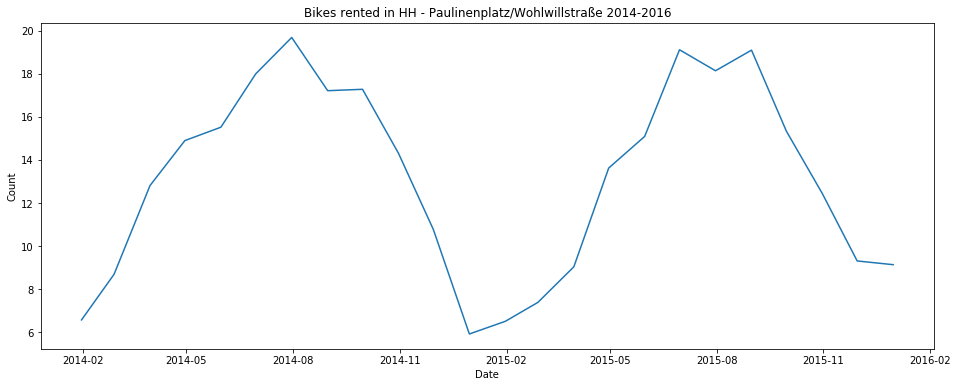

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

'''For visualization of trend and seasonality'''
count_viz = (test2[['Timestamp', 'Count']]).set_index(['Timestamp'])
downsample_series = count_viz.resample('M').mean()  


# data visualization via matplotlib and seaborn
'''Count over time in data:'''
plt.figure(figsize=(16,6))
plt.plot(downsample_series)
plt.title('Bikes rented in HH - Paulinenplatz/Wohlwillstraße 2014-2016')
plt.xlabel('Date')
plt.ylabel('Count')
None

#### 1b) Train test model

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [60]:
X = test2[['year', 'month', 'weekday', 'not_workday', 'hour',
       'school_holiday', 'Temp',
       'Windspeed', 'Rain']]
        # 'not_workday', 'not_workday_shift'

y = test2['Count']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((12506, 9), (4169, 9), (12506,), (4169,))

In [121]:
#pd.plotting.scatter_matrix(test2, figsize=(40,40), s=50)
#None

In [61]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

rfm = RandomForestRegressor(n_estimators=200, 
                            max_depth=8)

gbm = GradientBoostingRegressor(n_estimators=70, 
                                max_depth=8,
                                learning_rate=0.1,
                                random_state=1234)

In [177]:
rfm.fit(Xtrain,ytrain)
rfm.score(Xtrain,ytrain)

0.6982912464300853

In [180]:
scores = cross_val_score(rfm, Xtrain, ytrain, cv=5)
print(scores)
print(scores.mean())

[0.70392869 0.68153239 0.68693911 0.64190336 0.66557975]
0.6759766615666358


In [62]:
gbm.fit(Xtrain,ytrain)
gbm.score(Xtrain,ytrain)

0.8537354478474538

In [63]:
scores = cross_val_score(gbm, Xtrain, ytrain, cv=5)
print(scores)
print(scores.mean())

NameError: name 'cross_val_score' is not defined

In [64]:
from sklearn.model_selection import GridSearchCV

In [65]:
params = {'n_estimators': range(50,150,10), 'max_depth': range(6,10)}

In [191]:
grid = GridSearchCV(gbm, param_grid = params, cv=5)

In [192]:
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=1234, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(50, 150, 10), 'max_depth': range(6, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [193]:
grid.best_params_

{'max_depth': 8, 'n_estimators': 70}

In [194]:
grid.best_score_

0.7364801900904381

In [199]:
graph.head()

,year,month,weekday,not_workday,hour,school_holiday,Temp,Windspeed,Rain
0,2014,1,2,1,0,0,2.4,4,0
1,2014,1,2,1,1,0,2.1,6,0
2,2014,1,2,1,2,0,2.0,5,0
3,2014,1,2,1,3,0,2.1,5,0
4,2014,1,2,1,4,0,1.6,5,0


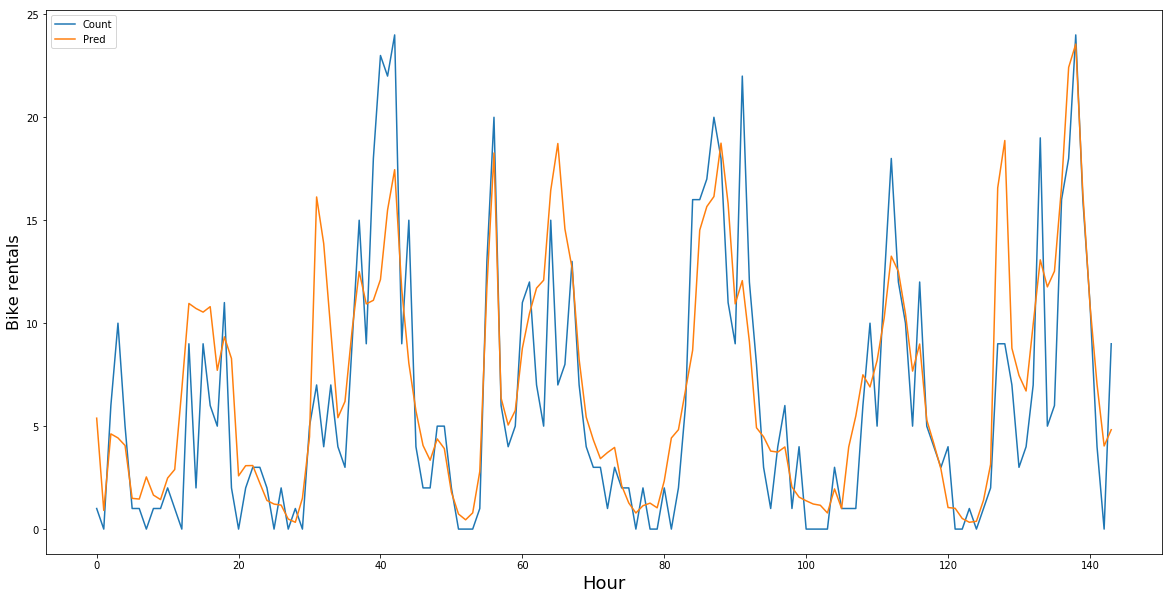

In [68]:
plt.figure(figsize=(20,10))
graph = test2[['year', 'day', 'month', 'weekday', 'not_workday', 'hour',
       'school_holiday', 'Temp',
       'Windspeed', 'Rain']]
graph = graph[graph.month == 1]
graph = graph[graph.year == 2014]
graph = graph[graph.day < 7]
X = graph.copy()
del X['day']
ypred = gbm.predict(X)
graph["Num"] = (graph["day"]-1) * 24 + graph["hour"]
graph = graph.sort_values("Num")
graph["Pred"] = ypred
graph["Count"] = y
graph["Diff"] = graph["Count"] - graph["Pred"]

plt.plot(graph["Num"], graph["Count"])
plt.plot(graph["Num"], graph["Pred"])
plt.legend(loc='upper left')
plt.xlabel('Hour', fontsize=18)
plt.ylabel('Bike rentals', fontsize=16)
plt.show()

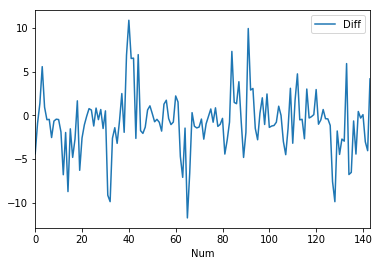

In [67]:
graph.plot.line(x="Num",y=["Diff"])